In [1]:
%matplotlib inline

# Analyze Visium H&E data

This tutorial shows how to apply Squidpy for the analysis of Visium
spatial transcriptomics data.

The dataset used here consists of a Visium slide of a coronal section of
the mouse brain. The original dataset is publicly available at the 10x
Genomics [dataset
portal](https://support.10xgenomics.com/spatial-gene-expression/datasets)
. Here, we provide a pre-processed dataset, with pre-annotated clusters,
in AnnData format and the tissue image in `squidpy.im.ImageContainer`
format.

A couple of notes on pre-processing:

> -   The pre-processing pipeline is the same as the one shown in the
>     original [Scanpy
>     tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/spatial/basic-analysis.html)
>     .
> -   The cluster annotation was performed using several resources, such
>     as the [Allen Brain
>     Atlas](https://mouse.brain-map.org/experiment/thumbnails/100048576?image_type=atlas)
>     , the [Mouse Brain gene expression atlas](http://mousebrain.org/)
>     from the Linnarson lab and this recent
>     [pre-print](https://www.biorxiv.org/content/10.1101/2020.07.24.219758v1)
>     .

::: seealso
See `sphx_glr_auto_tutorials_tutorial_visium_fluo.py` for a detailed
analysis example of image features.
:::

## Import packages & data

To run the notebook locally, create a conda environment as *conda env
create -f environment.yml* using this
[environment.yml](https://github.com/scverse/squidpy_notebooks/blob/main/environment.yml).


In [2]:
import scanpy as sc
import anndata as ad
import squidpy as sq

import numpy as np
import pandas as pd

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

# load the pre-processed dataset
img = sq.datasets.visium_hne_image()
adata = sq.datasets.visium_hne_adata()

/home/ifichtner/anaconda3/envs/squidpy/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.3 pandas==1.5.1 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.2 pynndescent==0.5.8
squidpy==1.2.3


In [3]:
img

ImageContainer[shape=(11757, 11291), layers=['image']]

In [4]:
adata

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

First, let\'s visualize cluster annotation in spatial context with
`squidpy.pl.spatial_scatter`.


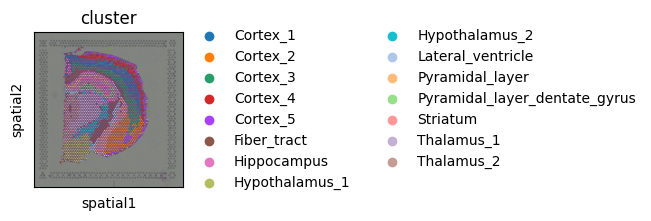

In [5]:
sq.pl.spatial_scatter(adata, color="cluster")

# Image features

Visium datasets contain high-resolution images of the tissue that was
used for the gene extraction. Using the function
`squidpy.im.calculate_image_features` you can calculate image features
for each Visium spot and create a `obs x features` matrix in `adata`
that can then be analyzed together with the `obs x gene` gene expression
matrix.

By extracting image features we are aiming to get both similar and
complementary information to the gene expression values. Similar
information is for example present in the case of a tissue with two
different cell types whose morphology is different. Such cell type
information is then contained in both the gene expression values and the
tissue image features.

Squidpy contains several feature extractors and a flexible pipeline of
calculating features of different scales and sizes. There are several
detailed examples of how to use `squidpy.im.calculate_image_features`.
`sphx_glr_auto_examples_image_compute_features.py` provides a good
starting point for learning more.

Here, we will extract [summary]{.title-ref} features at different crop
sizes and scales to allow the calculation of multi-scale features and
[segmentation]{.title-ref} features. For more information on the summary
features, also refer to
`sphx_glr_auto_examples_image_compute_summary_features.py`.


In [6]:
# calculate features for different scales (higher value means more context)
for scale in [1.0, 2.0]:
    feature_name = f"features_summary_scale{scale}"
    sq.im.calculate_image_features(
        adata,
        img.compute(),
        features="summary",
        key_added=feature_name,
        n_jobs=4,
        scale=scale,
    )


# combine features in one dataframe
adata.obsm["features"] = pd.concat(
    [adata.obsm[f] for f in adata.obsm.keys() if "features_summary" in f], axis="columns"
)
# make sure that we have no duplicated feature names in the combined table
adata.obsm["features"].columns = ad.utils.make_index_unique(adata.obsm["features"].columns)

100%|████████████| 2688/2688 [00:12<00:00, 208.86/s]


We can use the extracted image features to compute a new cluster
annotation. This could be useful to gain insights in similarities across
spots based on image morphology.


/tmp/ipykernel_21423/3320298302.py:12: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(features)


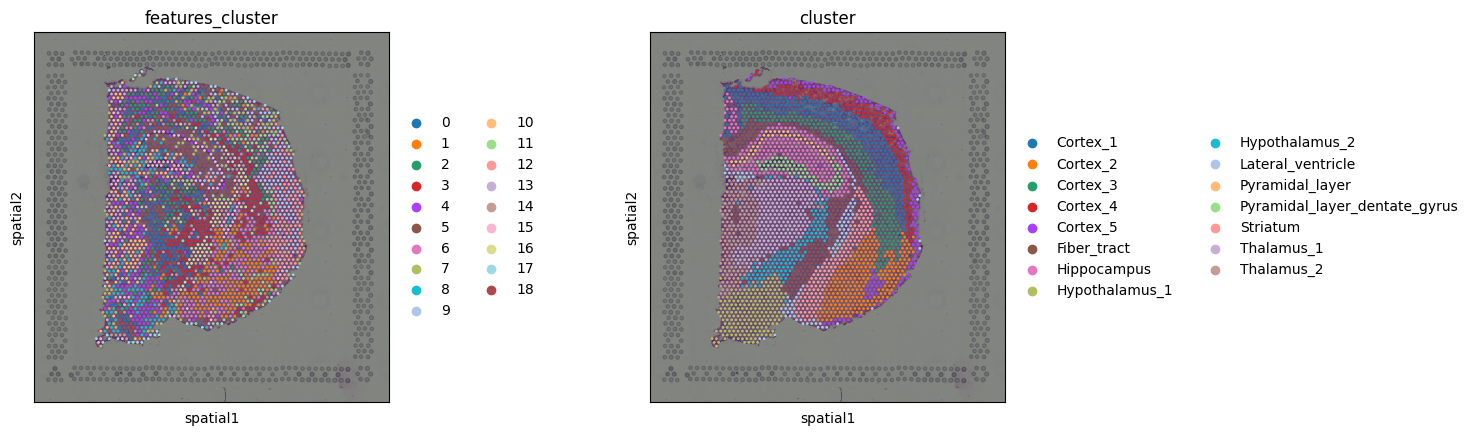

In [7]:
# helper function returning a clustering
def cluster_features(features: pd.DataFrame, like=None) -> pd.Series:
    """
    Calculate leiden clustering of features.

    Specify filter of features using `like`.
    """
    # filter features
    if like is not None:
        features = features.filter(like=like)
    # create temporary adata to calculate the clustering
    adata = ad.AnnData(features)
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(adata)
    # calculate leiden clustering
    sc.pp.pca(adata, n_comps=min(10, features.shape[1] - 1))
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)

    return adata.obs["leiden"]


# calculate feature clusters
adata.obs["features_cluster"] = cluster_features(adata.obsm["features"], like="summary")

# compare feature and gene clusters
sq.pl.spatial_scatter(adata, color=["features_cluster", "cluster"])

In [8]:
cluster_features.__annotations__

{'features': pandas.core.frame.DataFrame, 'return': pandas.core.series.Series}

Comparing gene and feature clusters, we notice that in some regions,
they look very similar, like the cluster *Fiber_tract*, or clusters
around the Hippocampus seems to be roughly recapitulated by the clusters
in image feature space. In others, the feature clusters look different,
like in the cortex, where the gene clusters show the layered structure
of the cortex, and the features clusters rather seem to show different
regions of the cortex.

This is only a simple, comparative analysis of the image features, note
that you could also use the image features to e.g. compute a common
image and gene clustering by computing a shared neighbors graph (for
instance on concatenated PCAs on both feature spaces).


# Spatial statistics and graph analysis

Similar to other spatial data, we can investigate spatial organization
by leveraging spatial and graph statistics in Visium data.

## Neighborhood enrichment

Computing a neighborhood enrichment can help us identify spots clusters
that share a common neighborhood structure across the tissue. We can
compute such score with the following function:
`squidpy.gr.nhood_enrichment`. In short, it\'s an enrichment score on
spatial proximity of clusters: if spots belonging to two different
clusters are often close to each other, then they will have a high score
and can be defined as being *enriched*. On the other hand, if they are
far apart, and therefore are seldom a neighborhood, the score will be
low and they can be defined as *depleted*. This score is based on a
permutation-based test, and you can set the number of permutations with
the `n_perms` argument (default is 1000).

Since the function works on a connectivity matrix, we need to compute
that as well. This can be done with `squidpy.gr.spatial_neighbors`.
Please see `sphx_glr_auto_examples_graph_compute_spatial_neighbors.py`
for more details of how this function works.

Finally, we\'ll directly visualize the results with
`squidpy.pl.nhood_enrichment`.


100%|███████████| 1000/1000 [00:00<00:00, 5584.12/s]


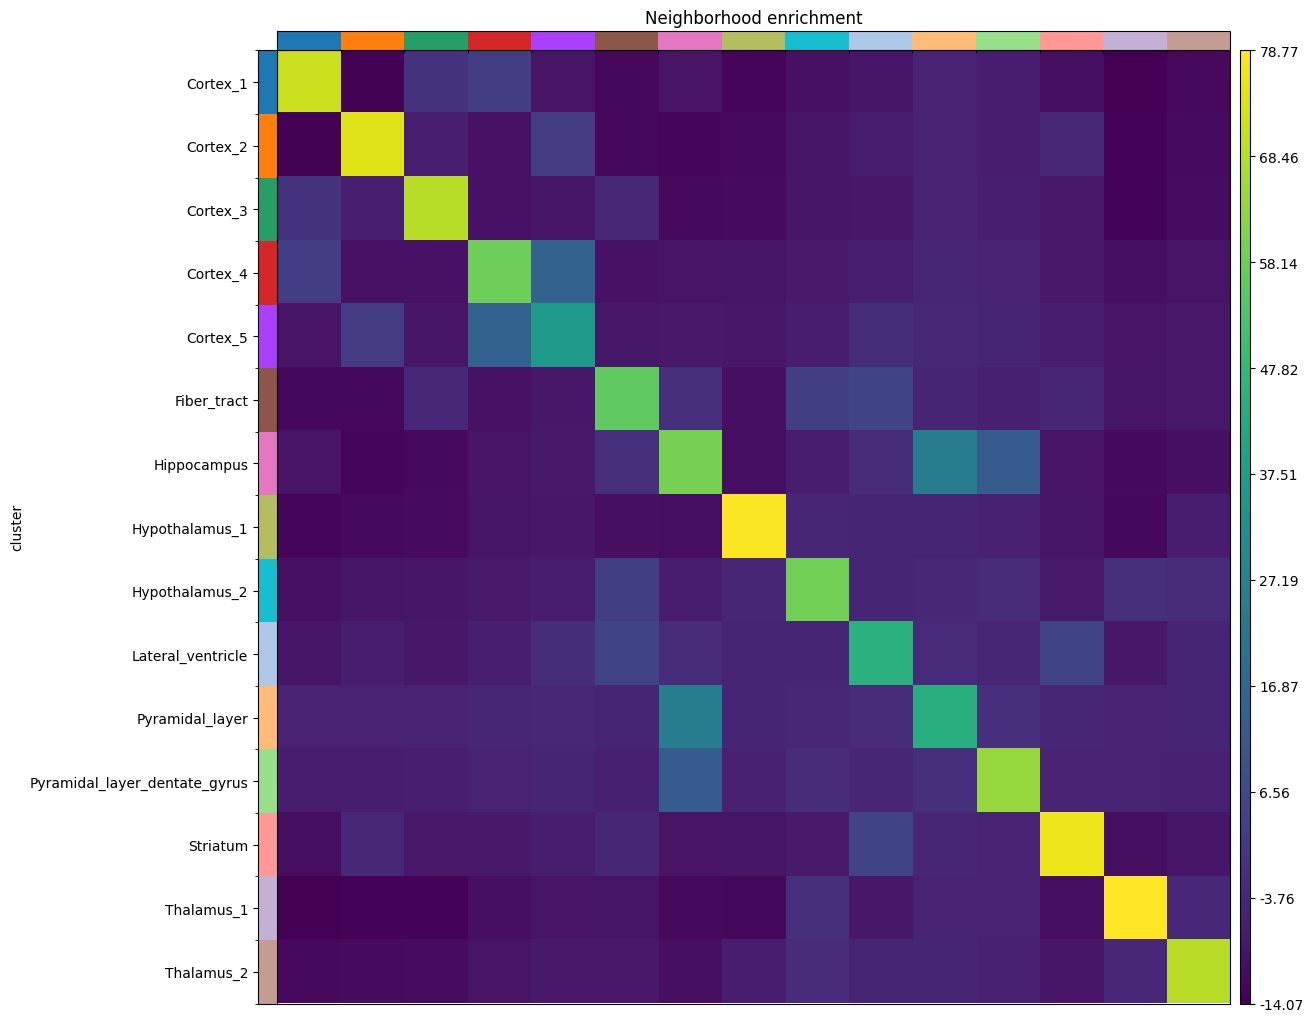

In [9]:
sq.gr.spatial_neighbors(adata)
sq.gr.nhood_enrichment(adata, cluster_key="cluster")
sq.pl.nhood_enrichment(adata, cluster_key="cluster")

Given the spatial organization of the mouse brain coronal section, not
surprisingly we find high neighborhood enrichment the Hippocampus
region: *Pyramidal_layer_dentate_gyrus* and *Pyramidal_layer* clusters
seems to be often neighbors with the larger *Hippocampus* cluster.


# Co-occurrence across spatial dimensions

In addition to the neighbor enrichment score, we can visualize cluster
co-occurrence in spatial dimensions. This is a similar analysis of the
one presented above, yet it does not operate on the connectivity matrix,
but on the original spatial coordinates. The co-occurrence score is
defined as:

$$\frac{p(exp|cond)}{p(exp)}$$

where $p(exp|cond)$ is the conditional probability of observing a
cluster $exp$ conditioned on the presence of a cluster $cond$, whereas
$p(exp)$ is the probability of observing $exp$ in the radius size of
interest. The score is computed across increasing radii size around each
observation (i.e. spots here) in the tissue.

We are gonna compute such score with `squidpy.gr.co_occurrence` and set
the cluster annotation for the conditional probability with the argument
`clusters`. Then, we visualize the results with
`squidpy.pl.co_occurrence`.


100%|███████████████████| 1/1 [00:00<00:00,  1.78/s]


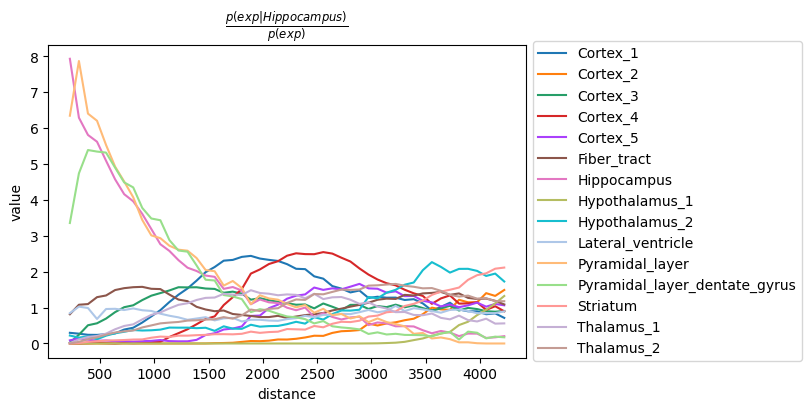

In [10]:
sq.gr.co_occurrence(adata, cluster_key="cluster")
sq.pl.co_occurrence(
    adata,
    cluster_key="cluster",
    clusters="Hippocampus",
    figsize=(8, 4),
)

The result largely recapitulates the previous analysis: the
*Pyramidal_layer* cluster seem to co-occur at short distances with the
larger *Hippocampus* cluster. It should be noted that the distance units
are given in pixels of the Visium `source_image`, and corresponds to the
same unit of the spatial coordinates saved in `adata.obsm['spatial']`.


> IDF: Let's investigate another co-occurance statistic of 'Cortex_1'
> Expected is the co-occurance within:
> - short distance with 'Cortex_3' and 'Cortex_4 
> - longer distance with 'Cortex_5' and maybe 'Fiber_tract'.

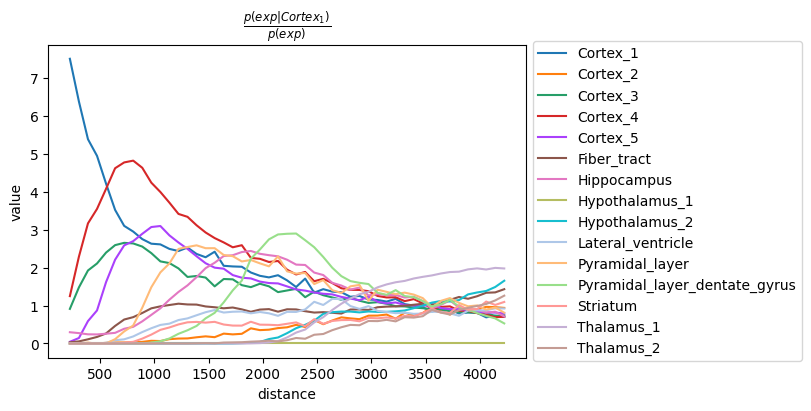

In [13]:
sq.pl.co_occurrence(
    adata, 
    cluster_key='cluster',
    clusters='Cortex_1',
    figsize=(8, 4)
)

> IDF: The categorical expectations were almost perfectly met.

# Ligand-receptor interaction analysis

We are continuing the analysis showing couple of feature-level methods
that are very relevant for the analysis of spatial molecular data. For
instance, after quantification of cluster co-occurrence, we might be
interested in finding molecular instances that could potentially drive
cellular communication. This naturally translates in a ligand-receptor
interaction analysis. In Squidpy, we provide a fast re-implementation
the popular method CellPhoneDB `cellphonedb`
([code](https://github.com/Teichlab/cellphonedb) ) and extended its
database of annotated ligand-receptor interaction pairs with the popular
database *Omnipath* `omnipath`. You can run the analysis for all
clusters pairs, and all genes (in seconds, without leaving this
notebook), with `squidpy.gr.ligrec`. Furthermore, we\'ll directly
visualize the results, filtering out lowly-expressed genes (with the
`means_range` argument) and increasing the threshold for the adjusted
p-value (with the `alpha` argument). We\'ll also subset the
visualization for only one source group, the *Hippocampus* cluster, and
two target groups, *Pyramidal_layer_dentate_gyrus* and *Pyramidal_layer*
cluster.


In [14]:
sq.gr.ligrec(
    adata,
    n_perms=100,
    cluster_key="cluster",
)
sq.pl.ligrec(
    adata,
    cluster_key="cluster",
    source_groups="Hippocampus",
    target_groups=["Pyramidal_layer", "Pyramidal_layer_dentate_gyrus"],
    means_range=(3, np.inf),
    alpha=1e-4,
    swap_axes=True,
)

100%|████| 100/100 [00:07<00:00, 12.89permutation/s]


AttributeError: 'int' object has no attribute 'values'

The dotplot visualization provides an interesting set of candidate
ligand-receptor annotation that could be involved in cellular
interactions in the Hippocampus. A more refined analysis would be for
instance to integrate these results with the results of a deconvolution
method, to understand what\'s the proportion of single-cell cell types
present in this region of the tissue.


# Spatially variable genes with Moran\'s I

Finally, we might be interested in finding genes that show spatial
patterns. There are several methods that aimed at address this
explicitly, based on point processes or Gaussian process regression
framework:

> -   *SPARK* -
>     [paper](https://www.nature.com/articles/s41592-019-0701-7#Abs1),
>     [code](https://github.com/xzhoulab/SPARK).
> -   *Spatial DE* -
>     [paper](https://www.nature.com/articles/nmeth.4636),
>     [code](https://github.com/Teichlab/SpatialDE).
> -   *trendsceek* -
>     [paper](https://www.nature.com/articles/nmeth.4634),
>     [code](https://github.com/edsgard/trendsceek).
> -   *HMRF* - [paper](https://www.nature.com/articles/nbt.4260),
>     [code](https://bitbucket.org/qzhudfci/smfishhmrf-py).

Here, we provide a simple approach based on the well-known [Moran\'s I
statistics](https://en.wikipedia.org/wiki/Moran%27s_I) which is in fact
used also as a baseline method in the spatially variable gene papers
listed above. The function in Squidpy is called
`squidpy.gr.spatial_autocorr`, and returns both test statistics and
adjusted p-values in `anndata.AnnData.var` slot. For time reasons, we
will evaluate a subset of the highly variable genes only.


In [15]:
genes = adata[:, adata.var.highly_variable].var_names.values[:1000]
sq.gr.spatial_autocorr(
    adata,
    mode="moran",
    genes=genes,
    n_perms=100,
    n_jobs=1,
)

100%|███████████████| 100/100 [00:55<00:00,  1.80/s]


The results are saved in `adata.uns['moranI']` slot. Genes have already
been sorted by Moran\'s I statistic.


In [16]:
adata.uns["moranI"].head(10)

,I,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh
Olfm1,0.763291,0.0,0.000131,0.0,0.009901,0.000226,0.0,0.0,0.011731
Plp1,0.747660,0.0,0.000131,0.0,0.009901,0.000250,0.0,0.0,0.011731
Itpka,0.727076,0.0,0.000131,0.0,0.009901,0.000254,0.0,0.0,0.011731
Snap25,0.720987,0.0,0.000131,0.0,0.009901,0.000256,0.0,0.0,0.011731
Nnat,0.708637,0.0,0.000131,0.0,0.009901,0.000211,0.0,0.0,0.011731
Ppp3ca,0.693320,0.0,0.000131,0.0,0.009901,0.000214,0.0,0.0,0.011731
Chn1,0.684957,0.0,0.000131,0.0,0.009901,0.000259,0.0,0.0,0.011731
Mal,0.679775,0.0,0.000131,0.0,0.009901,0.000270,0.0,0.0,0.011731
Tmsb4x,0.676719,0.0,0.000131,0.0,0.009901,0.000241,0.0,0.0,0.011731
Cldn11,0.674110,0.0,0.000131,0.0,0.009901,0.000275,0.0,0.0,0.011731


We can select few genes and visualize their expression levels in the
tissue with `squidpy.pl.spatial_scatter`.


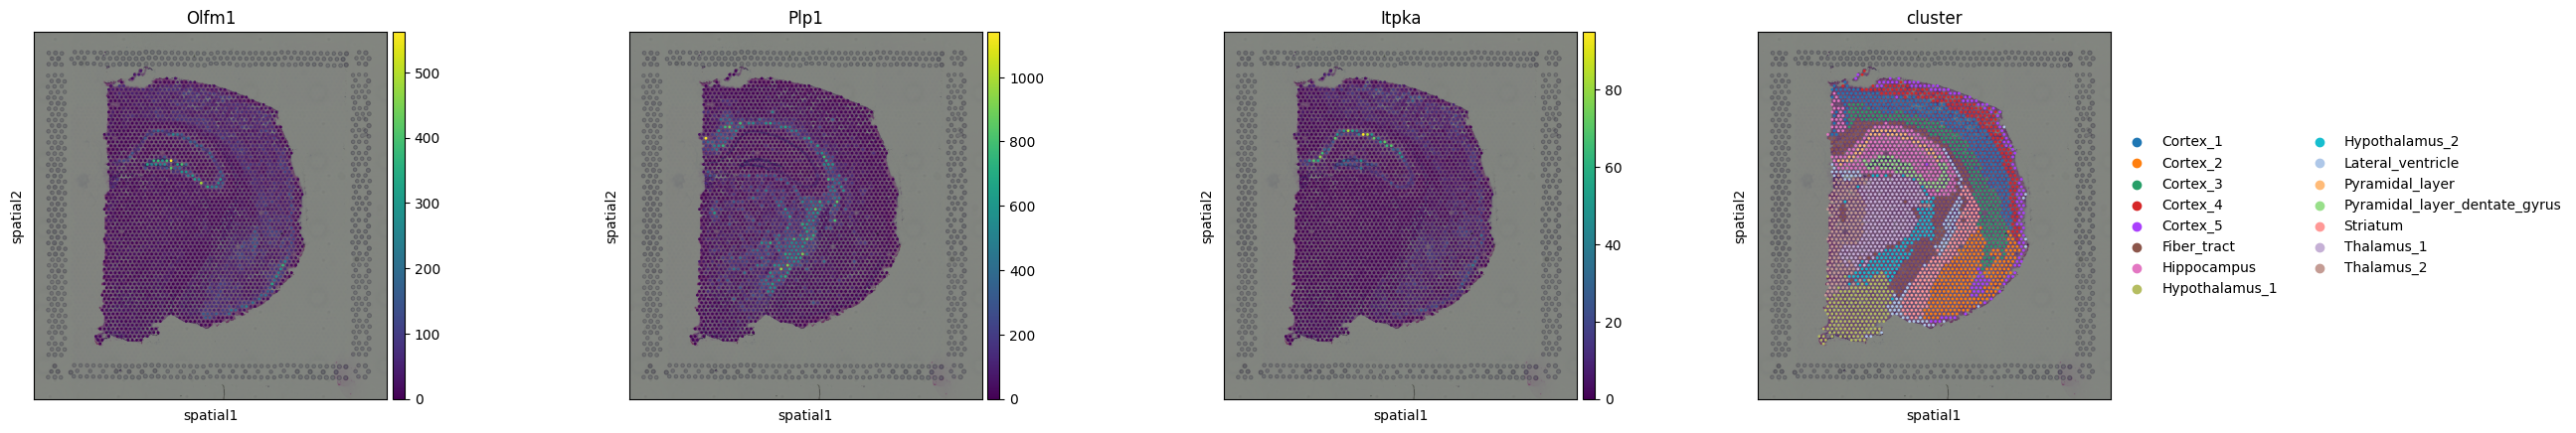

In [17]:
sq.pl.spatial_scatter(adata, color=["Olfm1", "Plp1", "Itpka", "cluster"])

Interestingly, some of these genes seems to be related to the
*pyramidal* layers and the *fiber tract*.


> IDF: explore some further genes

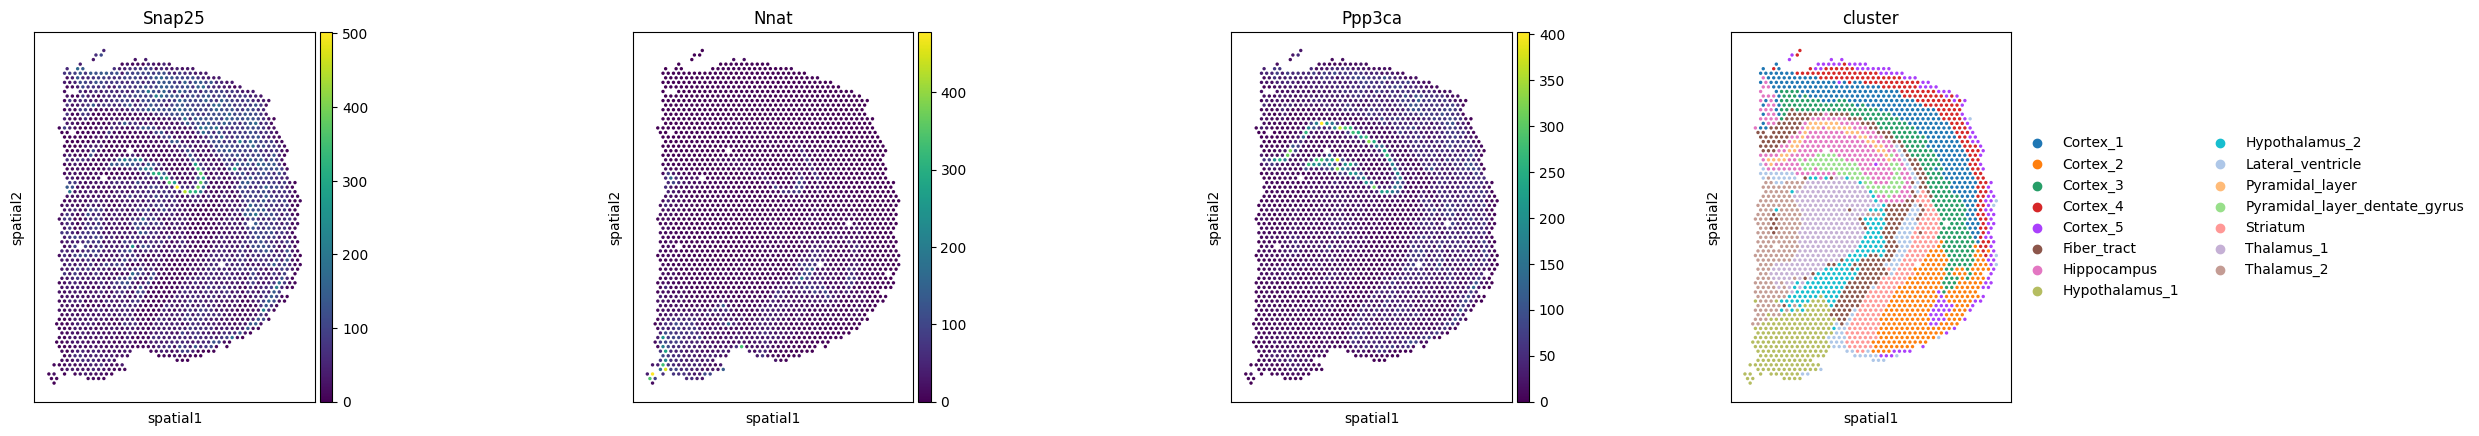

In [20]:
sq.pl.spatial_scatter(adata, color=['Snap25', 'Nnat', 'Ppp3ca', 'cluster'], img=False)

> IDF: Snap25 seems to be related to 'Pyramidal_layer_dentate_gyrus' and Pp3ca to both pyramidal layers